# Breast Cancer Detection Project

## Team Members
- **Aditya Thakur** (athakur32@gatech.edu)
- **Christopher Figueroa** (cfigueroa33@gatech.edu)
- **Kenneth Vallecillo** (kgonzalez41@gatech.edu)

## Overview
This project develops an object detection model to improve the accuracy of diagnosing breast cancer using ultrasound imaging. Utilizing the AI-First Technology medical image repository, this study focuses on detecting and classifying tumors as benign or malign.

## Methodology
Employing convolutional neural networks (CNNs), specifically the Faster R-CNN model, this project aims for high diagnostic accuracy. The methodology encompasses data preprocessing, model development, and rigorous performance evaluation using metrics like mean average precision (MAP) and intersection over union (IoU).

## Results & Conclusions
After extensive model training and optimization, including data augmentation techniques, the project achieved promising results in tumor detection accuracy. The work demonstrates the potential of deep learning in enhancing breast cancer diagnostics, with future directions focused on model refinement and exploring advanced neural network architectures.


#Readme

This project leverages the Faster R-CNN model implemented with PyTorch to analyze ultrasound images for medical diagnostics. It includes code for preparing the dataset, training and validating the model, evaluating its performance, and visualizing the results. Specifically, it focuses on detecting and classifying objects within ultrasound images, which can be crucial for medical diagnostics.

## Installation

Before running this project, ensure you have Python 3.8 or later installed. Additionally, you will need to install several dependencies, including PyTorch, torchvision, pandas, numpy, and matplotlib. You can install these dependencies via pip:

```bash
pip install torch torchvision pandas numpy matplotlib scikit-learn
```

Make sure your system has CUDA installed if you intend to use GPU acceleration for training and inference.

All project data can be found in the this google drive folder

[Project Gdrive Folder](https://drive.google.com/drive/folders/1KS5mWyLx1ogb5_LBiCtKO9KfeaKVYGu0?usp=sharing)

## Usage

To use this code, you will first need to prepare your dataset. The dataset should be in the form of a CSV file where each row represents an image with the following information: image path, bounding box coordinates, and class labels. An example row might look like this:

```bash
/path/to/image.jpg, [x_min, y_min, x_max, y_max], class_label
```
After preparing your dataset, update the paths in the `main()` function to point to your dataset CSV files and specify where to save the trained model and output images.

## Data Preparation

To prepare the data for analysis or model training, follow these steps for extracting the raw contents from the provided zip files by AI First Technology:

- **Extract Raw Data**
  - `Ultrasound - AI+ First.zip`: Extract this file to access the raw ultrasound images.
  - `Ultrasound - AI+ First-labeled.zip`: This file contains labeled ultrasound images. Extract it to access both the images and their json files.
  - `External_test_set.zip`: Extract this file to access an additional set of test images that can be used for validating the model's performance.

Ensure that each set of data is properly organized and stored in a structured manner after extraction for ease of access during the data preprocessing and model training phases. We recommend storing this inside google drive.



External_test_set google drive location

```bash
/drive/My Drive/omsa_practicum/images_exp032424/
```

Augmented images google drive location

```bash
/content/drive/My Drive/omsa_practicum/images_exp032524_augmented/
```

Output results folder

```bash
/content/drive/My Drive/omsa_practicum/metadata/
/content/drive/My Drive/omsa_practicum/models/pth/
/content/drive/My Drive/omsa_practicum/models/predictions

```



### Training the Model

To train the model, run Training Cell, you can adjust the EPOCHs per your requirement

The final trained model can be found in this location.
```bash
/content/drive/My Drive/omsa_practicum/models/pth/ultrasound_model_040224_final.pth
```
Click here to find the pytorch model
[Pytorch model](https://drive.google.com/file/d/1T2-eo2sgh3ZE3z6qW2igd2yJ75uie8g3/view?usp=sharing)


### References

For calculating the MAP we followed

[MAP Calculation](https://www.youtube.com/watch?v=FppOzcDvaDI&t=97s)

#Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Augmentation and Processing


In [ ]:
import albumentations as A
import cv2 as cv
import datetime
import json
import numpy as np
import os
import pandas as pd
import shutil
import torch
from distutils.dir_util import copy_tree
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img, img_to_array
from PIL import Image, ImageEnhance

def adjust_brightness(image_array, brightness_factor=1.2):
    # Brightness factor: <1 makes the image darker, >1 makes it brighter
    image_gen = ImageDataGenerator(brightness_range=[brightness_factor, brightness_factor])
    # ImageDataGenerator requires a 4D tensor, hence the np.expand_dims to add batch dimension
    image_array = np.expand_dims(image_array, axis=0)
    iterator = image_gen.flow(image_array, batch_size=1)
    bright_image = next(iterator).astype(np.uint8)[0]  # Retrieve the adjusted image and remove batch dimension
    return bright_image

def adjust_sharpness(image, factor=2.0):
    enhancer = ImageEnhance.Sharpness(image)
    img_enhanced = enhancer.enhance(factor)
    return img_enhanced

def clahe_image(image_path, clip_limit, tile_size):

    clahe_transform = cv.createCLAHE(clipLimit = clip_limit, tileGridSize= tile_size)
    image_to_clahe = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    clahe_image = clahe_transform.apply(image_to_clahe)

    return clahe_image

def color_jitter(image_array):
    transform = A.ColorJitter(p=1)
    augmented_image = transform(image=image_array)['image']
    return augmented_image

def gaussian_blur_image(image_array, kernel_size=(5, 5)):
    blurred_image = cv.GaussianBlur(image_array, kernel_size, 0)
    return blurred_image

def gaussian_noise_image(image_path, variance):
    test_image = img_to_array(Image.open(image_path))
    sigma = variance**0.5
    gaussian_noise = np.random.normal(loc=0, scale=sigma, size=test_image.shape)
    gaussian_noise = 255*gaussian_noise.reshape(test_image.shape)
    test_image = np.add(test_image, gaussian_noise)
    test_image[np.where(test_image<0)] = 0
    test_image[np.where(test_image>255)] = 255
    test_image = np.array(test_image, dtype='uint8')

def grid_distortion(image_array):
    transform = A.GridDistortion(p=1)
    augmented_image = transform(image=image_array)['image']
    return augmented_image

def random_erase(image_array):
    transform = A.Compose([
        A.CoarseDropout(max_holes=8, max_height=8, max_width=8, fill_value=0, p=1)
    ])
    augmented_image = transform(image=image_array)['image']
    return augmented_image

def salt_and_pepper_image(image_path):
    test_image = img_to_array(Image.open(image_path))
    w, h, c = test_image.shape

    for i in range(int(len(test_image.ravel())*0.05)):
        test_image[np.random.randint(0,w), np.random.randint(0,h),:] = 255*np.random.randint(0,2)
    test_image = np.array(test_image, dtype='uint8')
    return test_image

def process_images(root_folder):
  for subdir, dirs, files in os.walk(root_folder):
    for filename in files:

      if filename.endswith(('.jpg')):
        print("filename", filename)
        base, ext = os.path.splitext(filename)
        image_path = os.path.join(subdir, filename)
        image = Image.open(image_path)
        image_array = img_to_array(image)

        # Check and create Salt and Pepper image
        sp_image_path = os.path.join(subdir, f'sp_{filename}')
        if not os.path.exists(sp_image_path):
            sp_image_array = salt_and_pepper_image(image_array)
            sp_image = array_to_img(sp_image_array)
            sp_image.save(sp_image_path)

        # Check and create Gaussian Noise image
        gaussian_image_path = os.path.join(subdir, f'gaussian_{filename}')
        if not os.path.exists(gaussian_image_path):
            gaussian_image_array = gaussian_noise_image(image_array)
            gaussian_image = array_to_img(gaussian_image_array)
            gaussian_image.save(gaussian_image_path)

        # Check and create CLAHE image
        clahe_image_path = os.path.join(subdir, f'clahe_{filename}')
        if not os.path.exists(clahe_image_path):
            clahe_img = clahe_image(image_path)
            cv.imwrite(clahe_image_path, clahe_img)

        # Adjust Brightness
        brightness_image_path = os.path.join(subdir, f'brightness_{filename}')
        if not os.path.exists(brightness_image_path):
            brightness_image_array = adjust_brightness(image_array)
            brightness_image = array_to_img(brightness_image_array)
            brightness_image.save(brightness_image_path)

        # Gaussian Blur
        blur_image_path = os.path.join(subdir, f'blur_{filename}')
        if not os.path.exists(blur_image_path):
            blur_image_array = gaussian_blur_image(image_array)
            blur_image = array_to_img(blur_image_array)
            blur_image.save(blur_image_path)

        # Check and update JSON file if exists
        json_path = os.path.join(subdir, f'{base}.json')
        if os.path.isfile(json_path):
            for prefix in ['sp_', 'gaussian_', 'clahe_', 'brightness_', 'blur_']:
                new_json_path = os.path.join(subdir, f"{prefix}{base}.json")
                if not os.path.exists(new_json_path):
                    shutil.copy(json_path, new_json_path)

augmented_segment_row_information = []
augmentation_creation_date = str(datetime.date.today()).replace('-','')

image_directory = '/drive/My Drive/omsa_practicum/images_exp032424/' #Image directory can be adjusted to reflect location of images
augmented_image_directory = '/drive/My Drive/omsa_practicum/augmented_images_' + augmentation_creation_date + '/'


current_working_directory = os.getcwd()
ultrasound_dataset = os.listdir(current_working_directory + image_directory)

try:
    print('Copying Images from {}'.format(image_directory))
    shutil.copytree(current_working_directory+image_directory, current_working_directory+augmented_image_directory)
    print("Images copied to {}".format(augmented_image_directory))
    print("Folder copied successfully")
except Exception as e:
    print(f"Error occurred: {e}")

print('Generating Augmentations using images in {}'.format(augmented_image_directory))
process_images(augmented_image_directory)


Copying Images from /drive/My Drive/omsa_practicum/Copy of images_exp032424/


# Configuration File Generation


In [ ]:
#TODO add the csv generator function
import os
import csv
import json

def generate_csv_from_directory(directory, output_csv_path):
    with open(output_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Image_Path_JPG", "bbox", "Classification"])

        for root, dirs, files in os.walk(directory):
            for file_name in files:
                if file_name.endswith('.json'):
                    print("file_name", file_name)
                    file_path = os.path.join(root, file_name)
                    with open(file_path, 'r') as json_file:
                        data = json.load(json_file)
                        imagePath = data.get("imagePath", "")
                        shapes = data.get("shapes", [])
                        if shapes:
                            points = shapes[0].get("points", [])
                            if len(points) >= 2:
                                point1_x, point1_y = points[0]
                                point2_x, point2_y = points[1]

                    classification = "benign" if "benign" in root else "malign" if "malign" in root else ""
                    image_path_jpg = file_path.replace('.json', '.jpg')

                    # Adjusted for Unix-like path separators
                    Patient_ID = file_path.split("/")[-2]

                    writer.writerow([image_path_jpg, [point1_x, point1_y, point2_x, point2_y], classification])

# Update the directory_to_search to the Google Drive path

directory_to_search = '/content/drive/My Drive/omsa_practicum/images_exp032424/Ultrasound-labeled/' # change this to your image directory
output_csv_path = '/content/drive/My Drive/omsa_practicum/metadata/training_set_images_exp032524_v3.csv'


generate_csv_from_directory(directory_to_search, output_csv_path)

print("CSV file has been generated.")


file_name E02E5B96B9A44DBABEDBAE52E4CEF14A_6178971.json
file_name E02E5B96B9A44DBABEDBAE52E4CEF14A_6178970.json
file_name 20180720090622.json
file_name 20180720091141.json
file_name 3BD7CAF32DD142E397AC076FE5F79BBF_8306500.json
file_name 3BD7CAF32DD142E397AC076FE5F79BBF_8306504.json
file_name 3BD7CAF32DD142E397AC076FE5F79BBF_8306479.json
file_name 1.2.826.0.1.3680043.2.461.10889799.1302130936.json
file_name 1.2.826.0.1.3680043.2.461.10889799.2958215132.json
file_name 20181009110451.json
file_name 20181216110030.json
file_name 20181216110438.json
file_name 20181213092301.json
file_name 20181231094942.json
file_name 20181231095316.json
file_name 20181227091737.json
file_name 20181213095643.json
file_name 20190108164851.json
file_name 20190107110717.json
file_name 20190107110739.json
file_name 20190107110816.json
file_name 1.2.826.0.1.3680043.2.461.10889799.4126239069.json
file_name 1.2.826.0.1.3680043.2.461.10889800.259993021.json
file_name 1.2.826.0.1.3680043.2.461.10889800.2315368602.j

# Model Training and Evaluation

Using device: cuda
Train size: (8010, 3), Val size: (239, 3)
Loading model from /content/drive/My Drive/omsa_practicum/models/pth/ultrasound_model_040224_final.pth
Could not generate boxes for 2 images
Average IoU across validation images: 0.7028907592835077
Confusion Matrix
[[127   4]
 [ 16  90]]


<ipython-input-5-70819a29c07a>:671: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ['Negative', 'Positive'])
<ipython-input-5-70819a29c07a>:672: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + ['Negative', 'Positive'])


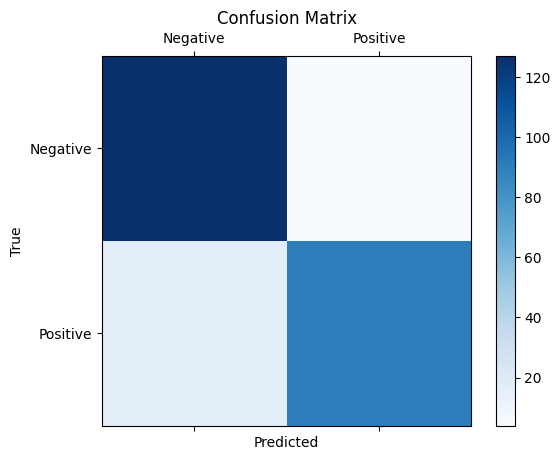

mAP at an IoU threshold of 0.5 - 0.797
mAP at an IoU threshold of 0.55 - 0.744
mAP at an IoU threshold of 0.6 - 0.694
mAP at an IoU threshold of 0.65 - 0.612
mAP at an IoU threshold of 0.7 - 0.506
mAP at an IoU threshold of 0.75 - 0.356
mAP at an IoU threshold of 0.8 - 0.132
mAP at an IoU threshold of 0.85 - 0.027
mAP at an IoU threshold of 0.9 - 0.004


In [ ]:
import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import torch
from keras.utils import array_to_img, img_to_array
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import DatasetFolder
from torchvision.io import read_image
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Dataset
from torchvision.transforms import Resize, Compose, ToTensor
from torchvision.transforms import functional as TF
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.io import read_image, write_jpeg
from torchvision.utils import draw_bounding_boxes, save_image
from torchvision.transforms import ColorJitter
from torchvision.transforms import Lambda
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageOps
from torchvision.transforms.functional import to_tensor, resize
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_V2_Weights
from PIL import ImageDraw, ImageFont
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_columns', None)


# 1. Dataset Preparation

class UltrasoundDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        # Read image and convert to RGB
        image = Image.open(row['Image_Path_JPG']).convert('RGB') # This ensures 3 channels

        # Scale bbox coordinates directly within tensor initialization
        original_size = torch.tensor([image.width, image.height, image.width, image.height], dtype=torch.float)
        bbox = torch.tensor(eval(row['bbox']), dtype=torch.float)
        # Scale bbox to new size (600x600) directly
        scale_factors = torch.tensor([600, 600] * 2) / original_size
        scaled_bbox = bbox * scale_factors

        image = self.transform(image) if self.transform else resize(to_tensor(image), (600, 600))

        labels = torch.tensor([row['Classification'] + 1], dtype=torch.int64)
        target = {'boxes': scaled_bbox, 'labels': labels, 'image_id': torch.tensor([idx])}
        return image, target

    def __len__(self):
        return len(self.dataframe)


def get_model(num_classes):
    # Specify the pretrained weights
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT

    # Load the pre-trained model with the specified weights
    model = fasterrcnn_resnet50_fpn_v2(weights=weights)

    # Get the number of input features for the classifier from the loaded model weights
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one (adjust the number of classes)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# 3. Training and Validation Loops
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    num_batches = 0
    total_loss = 0
    for images, targets_batched in data_loader:
        num_batches += 1
        print('\r' + '{}/{}'.format(num_batches, len(data_loader)), end="\r")
        sys.stdout.write("\033[F")
        if torch.cuda.is_available():
            images = [image.cuda() for image in images]
            targets = []
            for i in range(len(targets_batched['image_id'])):
                target = {'boxes': targets_batched['boxes'][i].unsqueeze(0).cuda(), 'labels': targets_batched['labels'][i].cuda(), 'image_id': targets_batched['image_id'][i].cuda()}
                targets.append(target)
        else:
            images = [image.to(device) for image in images]
            targets = []
            for i in range(len(targets_batched['image_id'])):
                target = {'boxes': targets_batched['boxes'][i].unsqueeze(0).cuda(), 'labels': targets_batched['labels'][i].cuda(), 'image_id': targets_batched['image_id'][i].cuda()}
                targets.append(target)
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        total_loss += losses.item()

    average_loss = total_loss / len(data_loader)

    return average_loss


# def adjust_boxes_to_original(pred_boxes, orig_dim, new_dim=(600, 600)):
#     """
#     Adjust bounding box coordinates from resized dimensions back to original dimensions.
#     """
#     orig_width, orig_height = orig_dim
#     new_width, new_height = new_dim
#     scale_x, scale_y = orig_width / new_width, orig_height / new_height

#     # Adjust box coordinates
#     scaled_boxes = pred_boxes.clone()
#     scaled_boxes[:, [0, 2]] *= scale_x  # Adjust x coordinates
#     scaled_boxes[:, [1, 3]] *= scale_y  # Adjust y coordinates

#     return scaled_boxes


def rescale_boxes_to_original(bbox, current_dims, original_dims):
    """
    Rescale bounding boxes from current dimensions back to the original dimensions.

    Parameters:
    - bbox: Tensor of shape [N, 4] representing bounding boxes. Each box is defined as [x_min, y_min, x_max, y_max].
    - current_dims: Tuple or list with two elements (current_width, current_height) representing the dimensions to which the boxes are currently scaled.
    - original_dims: Tuple or list with two elements (original_width, original_height) representing the original dimensions of the images from which the boxes were derived.

    Returns:
    - rescaled_bbox: Tensor of shape [N, 4] representing bounding boxes rescaled to the original image dimensions.
    """
    # Calculate the scale factors for x and y dimensions to go back to the original dimensions
    scale_factors = torch.tensor(original_dims * 2, dtype=torch.float32) / torch.tensor(current_dims * 2, dtype=torch.float32)

    # Apply the scale factors to rescale the bounding boxes
    rescaled_bbox = bbox * scale_factors

    return rescaled_bbox

def evaluate(pred_path, model, data_loader, device, dataframe, confidence_threshold=0.8):
    model.eval()
    total_loss = 0
    total = 0
    mean_ap_list = []
    with torch.no_grad():
        for images, targets_batched in data_loader:

            images = list(image.to(device) for image in images)

            targets = []
            for i in range(len(targets_batched['image_id'])):
                target = {'boxes': targets_batched['boxes'][i].unsqueeze(0).cuda(), 'labels': targets_batched['labels'][i].cuda(), 'image_id': targets_batched['image_id'][i].cuda()}
                targets.append(target)

            outputs = model(images)

            model.train()
            loss_dict = model(images, targets)
            model.eval()


            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
            total += 1

            mean_ap = mAP(outputs, targets_batched, 0.5)
            mean_ap_list.append(mean_ap)

            for i, image in enumerate(images):

                pred_boxes = torch.reshape(outputs[i]['boxes'].data.cpu()[0], (1, 4)) if outputs[i]['boxes'].data.cpu().size()[0]>0 else outputs[i]['boxes'].data.cpu()
                # Extract original image path from dataframe
                original_img_path = dataframe.iloc[targets_batched['image_id'][i].item()]['Image_Path_JPG']

                orig_image_size = Image.open(original_img_path).size  # Original dimensions (width, height)

                image = TF.convert_image_dtype(image, dtype=torch.uint8)  # Convert back to uint8

                if '_SAM' in original_img_path:
                    original_img_json = original_img_path[:-8] +'.json'
                else:
                    original_img_json = original_img_path[:-4] +'.json'

                json_file = open(original_img_json)
                json_data = json.load(json_file)

                tumor_points = np.array(json_data['shapes'][0]['points']).astype(float)
                gt_box = torch.tensor(tumor_points).view(1, 4).float()

                orig_image = read_image(original_img_path).float() / 255.0  # Reload the original image
                orig_image = TF.convert_image_dtype(orig_image, dtype=torch.uint8)

                # pred_boxes = rescale_boxes_to_original(pred_boxes, (600, 600), orig_image_size)
                # gt_box = rescale_boxes_to_original(gt_box, (600, 600), orig_image_size)


                image_with_boxes = draw_bounding_boxes(orig_image.cpu(), gt_box, colors="green", width=3)
                image_with_boxes = draw_bounding_boxes(image_with_boxes.cpu(), pred_boxes, colors="red", width=3)


                pil_image_with_boxes = TF.to_pil_image(image_with_boxes.cpu())


                json_file.close()

                pil_image_with_boxes = TF.to_pil_image(image_with_boxes)

                # Specify the directory and filename
                dir_path = pred_path

                _, file_name = os.path.split(original_img_path)
                file_name_without_ext, ext = os.path.splitext(file_name)
                new_file_name = f"{file_name_without_ext}_predictions_bbox{ext}"
                new_img_path = os.path.join(dir_path, new_file_name)

                # Save the image with IoU value
                pil_image_with_boxes.save(new_img_path)

    # Calculate mAP
    mean_loss = total_loss / total if total > 0 else 0

    return mean_loss, sum(mean_ap_list)/len(mean_ap_list)

def IoU(Pred_Box, True_Box):
    IoU = 0

    x_true_0, y_true_0, x_true_1, y_true_1 = True_Box
    true_box_area = (x_true_1-x_true_0)*(y_true_1 - y_true_0)

    if Pred_Box:
        x_pred_0, y_pred_0, x_pred_1, y_pred_1 = Pred_Box
        pred_box_area = (x_pred_1 - x_pred_0)*(y_pred_1 - y_pred_0)

        x_int_0 = np.max([x_true_0, x_pred_0])
        y_int_0 = np.max([y_true_0, y_pred_0])
        x_int_1 = np.min([x_true_1, x_pred_1])
        y_int_1 = np.min([y_true_1, y_pred_1])

        int_width = x_int_1 - x_int_0
        int_height = y_int_1 - y_int_0

        if int_width < 0 or int_height < 0:
            int_area = 0
        else:
            int_area = int_width*int_height
        union_area = true_box_area + pred_box_area - int_area

        IoU = int_area/union_area
        return IoU
    else:
        return IoU

def mAP(prediction, target, iou_threshold, n_classes = 3):
    from collections import Counter

    average_precisions = []
    pred_boxes = []
    true_boxes = []

    for image in range(len(target['image_id'])):
        n_predictions = prediction[image]['labels'].shape
        pred_index = torch.tensor(image, device = 'cuda:0').repeat(n_predictions).unsqueeze(1)
        pred_labels = prediction[image]['labels'].unsqueeze(1)
        pred_scores = prediction[image]['scores'].unsqueeze(1)
        pred_bbox = prediction[image]['boxes']
        predicted_box = torch.cat((pred_index, pred_labels, pred_scores, pred_bbox), dim = 1).tolist()
        pred_boxes.extend(predicted_box)
        true_boxes.append([image, target['labels'][image], target['boxes'][image]])


    for c in range(n_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1].item() == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)
        detections.sort(key = lambda x: x[2], reverse = True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [bbox for bbox in ground_truths if bbox[0] == detection[0]]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = IoU(detection[3:], gt[2])

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1
        TP_cumsum = torch.cumsum(TP, dim = 0)
        FP_cumsum = torch.cumsum(FP, dim = 0)

        recalls = TP_cumsum / (total_true_bboxes + 1e-6)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + 1e-6))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        average_precisions.append(torch.trapz(precisions, recalls))

    print('Average Precisions')
    print(average_precisions)
    return sum(average_precisions)/2

def mAP_eval(pred_boxes, true_boxes, iou_threshold, n_classes = 3):
    from collections import Counter

    average_precisions = []

    for c in range(n_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1].item() == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)
        detections.sort(key = lambda x: x[2], reverse = True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [bbox for bbox in ground_truths if bbox[0] == detection[0]]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = IoU(detection[3], gt[2])

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1
        TP_cumsum = torch.cumsum(TP, dim = 0)
        FP_cumsum = torch.cumsum(FP, dim = 0)

        recalls = TP_cumsum / (total_true_bboxes + 1e-6)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + 1e-6))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions)/2

def plot_learning_curves(train_losses, val_losses=None, filename="learning_curves.png"):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o', linestyle='-', linewidth=2, markersize=5)
    if val_losses:
        plt.plot(epochs, val_losses, label='Val Loss', color='red', marker='s', linestyle='--', linewidth=2, markersize=5)
    plt.title('Training and Validation Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()


def plot_map_curves(maps, filename="map_curves.png"):
    epochs = range(1, len(maps) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, maps, label='MAP', color='blue', marker='o', linestyle='-', linewidth=2, markersize=5)
    plt.title('MAP Curve')
    plt.xlabel('Epoch')
    plt.ylabel('MAP')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()

def save_losses_to_csv(train_losses, val_losses, csv_path):

    df_losses = pd.DataFrame({
        "Epoch": range(1, len(train_losses) + 1),
        "Train Loss": train_losses,
        "Validation Loss": val_losses
    })

    df_losses.to_csv(csv_path, index=False)

def save_maps_to_csv(maps, csv_path):
    df_maps = pd.DataFrame({
        "Epoch": range(1, len(maps) + 1),
        "mAP": maps
    })
    df_maps.to_csv(csv_path, index=False)

def main():

    start_time = time.time()  # Start timing

    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Data preparation

    base_path = r"/content/drive/My Drive/omsa_practicum/"

    # Input Paths
    train_data_csv_path =             base_path+"metadata/training_set_images_exp032524_augmented.csv"
    valid_data_csv_path =             base_path+"metadata/validation_segmentation_gdrive.csv"

    # Output paths
    results_base_path =               base_path+"models/results/"
    pth_base_path =                   base_path+"models/pth/"
    pred_base_path =                  base_path+"models/trainined_predictions/"
    pretained_pred_base_path =       base_path+"models/pretrained_predictions/"

    # pretrained model path
    pretrained_model_path = '/content/drive/My Drive/omsa_practicum/models/pth/ultrasound_model_040224_final.pth'

    os.makedirs(results_base_path, exist_ok=True)
    os.makedirs(pth_base_path, exist_ok=True)
    os.makedirs(pred_base_path, exist_ok=True)
    os.makedirs(pretained_pred_base_path, exist_ok=True)

    # Read the CSV file into a DataFrame
    train_df = pd.read_csv(train_data_csv_path)
    # List of prefixes to look for
    prefixes = ['sp_', 'gaussian_', 'clahe_', 'brightness_', 'blur_']
    # Filter based on the absence of the prefixes
    mask_no_prefix = ~train_df['Image_Path_JPG'].str.split('/').str[-1].apply(lambda x: any(x.startswith(prefix) for prefix in prefixes))
    filtered_df = train_df[mask_no_prefix]
    # Now, select images with those prefixes
    mask_with_prefix = train_df['Image_Path_JPG'].str.split('/').str[-1].apply(lambda x: any(x.startswith(prefix) for prefix in prefixes))
    with_prefix_df = train_df[mask_with_prefix]
    # Randomly select 20% of these rows
    np.random.seed(42)  # Ensure reproducibility
    rand_sample = with_prefix_df.sample(frac=0.8)
    # Concatenate the filtered_df with the random sample of images with prefixes
    final_df = pd.concat([filtered_df, rand_sample])
    # Shuffle the final DataFrame to mix rows
    train_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

    train_df['Classification'] = (train_df['Classification'] != 'benign').astype(int)  # 0 for 'benign', 1 otherwise

    val_df = pd.read_csv(valid_data_csv_path).sample(frac=1, random_state=42).reset_index(drop=True)

    print(f'Train size: {train_df.shape}, Val size: {val_df.shape}')

    train_transforms = Compose([
        Resize((600, 600)),
        ToTensor(),
    ])

    # Datasets and DataLoaders
    BATCH_SIZE = 10
    train_loader = DataLoader(UltrasoundDataset(train_df, transform=train_transforms), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(UltrasoundDataset(val_df), batch_size=BATCH_SIZE, shuffle=False)

    # Model setup
    experiment_ = "041024_exp11"
    num_classes = 3  # Assuming 3 classes for your use case
    num_epochs = 10
    model = get_model(num_classes=num_classes).to(device)

    # checkpoint_path = pth_base_path+"ultrasound_model_"+experiment_+".pth"

    # Change this flag to use a trained model
    # TRAINING_MODE = True
    TRAINING_MODE = False

    # Check if checkpoint exists
    if os.path.exists(pretrained_model_path) and not TRAINING_MODE:
        print(f"Loading model from {pretrained_model_path}")
        model.load_state_dict(torch.load(pretrained_model_path))
        model = model.to(device)
    else:
        print("Checkpoint not found. Starting training process.")

        optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

        # Training and evaluation
        train_losses, val_losses, maps = [], [], []

        for epoch in range(num_epochs):
            epoch_start_time = time.time()  # Start timing the epoch
            print(f'Epoch {epoch+1}/{num_epochs} started.')

            train_loss = train_one_epoch(model, optimizer, train_loader, device)
            train_losses.append(train_loss)

            val_loss, map_score = evaluate(pred_base_path, model, val_loader, device, val_df)
            val_losses.append(val_loss)

            maps.append(map_score)

            # Step the scheduler
            scheduler.step()

            epoch_end_time = time.time()  # End timing the epoch
            print(f'Epoch {epoch+1}/{num_epochs} completed. Train Loss: {train_loss}, Val mAP: {map_score}. Epoch Time: {epoch_end_time - epoch_start_time:.2f} seconds.')


            learning_curve_path = results_base_path+"learning_curves_"+experiment_+".png"
            # Define the path where you want to save the losses CSV
            losses_csv_path = results_base_path+"losses_"+experiment_+".csv"
            # Call the function with your data
            save_losses_to_csv(train_losses, val_losses, losses_csv_path)
            plot_learning_curves(train_losses, val_losses, learning_curve_path)

            map_curve_path = results_base_path+"map_curves_"+experiment_+".png"
            # Define the path where you want to save the mAP CSV
            maps_csv_path = results_base_path+"maps_"+experiment_+".csv"
            # Call the function with your data
            save_maps_to_csv(maps, maps_csv_path)
            plot_map_curves(maps, map_curve_path)

            # Model saving
            model_save_path = os.path.join(pth_base_path, "ultrasound_model_"+experiment_+".pth")
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')

            end_time = time.time()  # End timing
            total_time = end_time - start_time
            print(f'Total Training and Evaluation Time: {total_time:.2f} seconds')
    # .....
    n_no_boxes = 0
    pred_labels = []
    true_labels = []
    image_ious = []

    model_predictions = []
    model_targets = []
    image_id = 0
    for check_image_path in val_df['Image_Path_JPG']:

      if 'benign' in check_image_path:
        classification = 1
        dir_path = pretained_pred_base_path+'benign/'
        ground_truth_text = 'benign'
      else:
        classification = 2
        dir_path = pretained_pred_base_path+'malignant/'
        ground_truth_text = 'malignant'

      os.makedirs(dir_path, exist_ok=True)

      image_bbox = list(map(int, val_df.loc[val_df['Image_Path_JPG'] == check_image_path]['bbox'].to_list()[0].strip('][').split(', ')))
      test_image = Image.open(check_image_path).convert('RGB')

      test_tensor = to_tensor(test_image)

      model.eval()
      results = model([test_tensor.to(device)])

      if len(results[0]['boxes']) < 1:
        n_no_boxes += 1
        # print("image_path", check_image_path)
        pass
      else:
        pred_label = results[0]['labels'][0].item()
        true_labels.append(classification)
        pred_labels.append(pred_label)
        pred_bbox = results[0]['boxes'][0].tolist()
        pred_score = results[0]['scores'][0].item()

        image_ious.append(IoU(pred_bbox, image_bbox))
        model_predictions.append([image_id, pred_label, pred_score, pred_bbox])
        model_targets.append([image_id, torch.tensor(classification), image_bbox])

        #Draw box on image and save results
        if pred_label == 1:
            # LimeGreen with 50% transparency
            color = 'limegreen'
            color_ = (50, 205, 50, 192)  # Adding alpha value for transparency
        else:
            # SkyBlue with 50% transparency
            color = 'skyblue'
            color_ = (135, 206, 235, 192)  # Adding alpha value for transparency

        orig_image = read_image(check_image_path).float() / 255.0  # Reload the original image
        orig_image = TF.convert_image_dtype(orig_image, dtype=torch.uint8)
        predicted_box = torch.reshape(torch.tensor(pred_bbox), (1, 4))
        x1, y1, x2, y2 = predicted_box.tolist()[0]
        gt_box = torch.reshape(torch.tensor(image_bbox), (1, 4))
        image_with_boxes = draw_bounding_boxes(orig_image.cpu(), predicted_box, colors=color, width=3)
        image_with_boxes = draw_bounding_boxes(image_with_boxes, gt_box, colors="red", width=3)
        w, h = orig_image.shape[1], orig_image.shape[2]
        # Convert tensor image to PIL for drawing text
        pil_image_with_boxes = TF.to_pil_image(image_with_boxes)
        # Draw IoU value on the image
        draw = ImageDraw.Draw(pil_image_with_boxes)
        font = ImageFont.load_default()  # Load a default font
        iou_text = f"IoU: {IoU(pred_bbox, image_bbox):.2f}"  # Format IoU to 2 decimal places
        confidence_text = f"Confidence: {100*pred_score:.1f}"
        gt_text = "Ground Truth: {}".format(ground_truth_text)
        # Draw Rectangle for text

        draw.rectangle([x1-15, y1-35, x2+30, y1], fill = color_)
        # draw.rectangle([(w/2) - 15, 0, (w/2) + 135, 15], fill = 'white')
        draw.text((x1 - 10, y1 - 10), iou_text, fill=(0, 0, 0), font=font)
        draw.text((x1 -10, y1 - 20), confidence_text, fill = (0, 0, 0), font = font)
        draw.text((x1 -10, y1 - 30), gt_text, fill = (0, 0, 0), font = font)

        _, file_name = os.path.split(check_image_path)
        file_name_without_ext, ext = os.path.splitext(file_name)
        new_file_name = f"{file_name_without_ext}_predictions_bbox{ext}"
        new_img_path = os.path.join(dir_path, new_file_name)

        # Save the image with IoU value
        pil_image_with_boxes.save(new_img_path)

        image_id += 1

    print('Could not generate boxes for {} images'.format(n_no_boxes))
    print('Average IoU across validation images: {}'.format(np.mean(image_ious)))

    confusion_matrix_ = confusion_matrix(true_labels, pred_labels)
    print('Confusion Matrix')
    print(confusion_matrix_)

    confussion_matrix_path = results_base_path+"confussion_matrix.png"

    fig, ax = plt.subplots()
    cax = ax.matshow(confusion_matrix_, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    ax.set_xticklabels([''] + ['Negative', 'Positive'])
    ax.set_yticklabels([''] + ['Negative', 'Positive'])

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(confussion_matrix_path)
    plt.show()
    plt.close()

    for thres in np.arange(0.5,0.95,0.05):
      mean_ap = mAP_eval(model_predictions, model_targets, thres)
      print('mAP at an IoU threshold of {} - {}'.format(np.around(thres, 2), f"{mean_ap:.3f}"))


if __name__ == '__main__':
    main()

